# Multiple Regression and Confounds

In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc as pm
from quap import quap
import arviz as az
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.special import expit as logistic

palette=['cyan', "#e06666"]
%config InlineBackend.figure_format = 'svg'

## The Four Elemental Confounds

### The Fork
#### $X \leftarrow Z \rightarrow Y$
$Z$&nbsp;is a "confounder", X and Y are associated. Once stratified by $Z$, the association between X and Y disappears.

In [36]:
n = 1000
# equal probability of Z = 0 and Z = 1
Z = stats.bernoulli.rvs(0.5, size=n)
# each X is dependent on corresponding Z
X = stats.bernoulli.rvs((1 - Z) * 0.1 + Z * 0.9)
# each Y is dependent on corresponding Z
Y = stats.bernoulli.rvs((1 - Z) * 0.1 + Z * 0.9)

df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
df[['X', 'Y']].value_counts()

X  Y
1  1    438
0  0    385
   1     95
1  0     82
Name: count, dtype: int64

In [37]:
df['X'].corr(df['Y'])

0.6452822650737117

Stratify by $Z$

In [38]:
df[df.Z == 0][['X', 'Y']].value_counts()

X  Y
0  0    382
   1     50
1  0     41
   1      5
Name: count, dtype: int64

In [39]:
# little/no association between X and Y values conditioned on Z = 0
df[df.Z == 0][['X', 'Y']].X.corr(df[df.Z == 0].Y)

-0.0065111202777120335

In [40]:
n = 500
Z = stats.bernoulli.rvs(0.5, size=n)
X = stats.norm.rvs(2 * Z - 1)
Y = stats.norm.rvs(2 * Z - 1)

df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

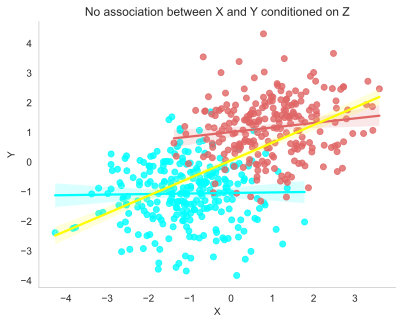

In [41]:
# sns.regplot combines scatterplot and linear regression line
sns.regplot(x='X', y='Y', data=df[df.Z == 0], color=palette[0])
sns.regplot(x='X', y='Y', data=df[df.Z == 1], color=palette[1])
sns.regplot(x='X', y='Y', data=df, scatter=False, color='yellow')
plt.title("No association between X and Y conditioned on Z")
plt.grid(False)
sns.despine()

#### Fork Example
Why do regions of the USA with higher rates of marriage also have higher rates of divorce?

In [42]:
df = pd.read_csv("Data/WaffleDivorce.csv", sep=";", header=0)
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Fork: Marriage <- Age at Marriage -> Divorce

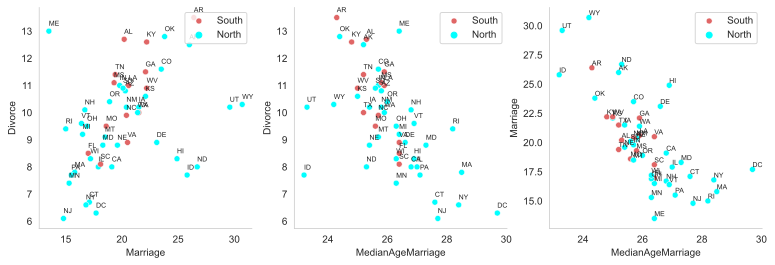

In [43]:
fig, axs = plt.subplots(ncols=3, figsize=(13, 4))

# Marriage -> Divorce
sns.scatterplot(data=df, x="Marriage", y="Divorce", hue="South", palette=palette, ax=axs[0])
axs[0].legend(loc='upper right', labels=['South', 'North'])
axs[0].grid(False)
sns.despine()

for line in range(0, df.shape[0]):
    axs[0].text(df.Marriage[line], df.Divorce[line] + 0.2, df.Loc[line], size='x-small')

# Age at Marriage -> Divorce
sns.scatterplot(data=df, x="MedianAgeMarriage", y="Divorce", hue="South", palette=palette,  ax=axs[1])
axs[1].legend(loc='upper right', labels=['South', 'North'])
axs[1].grid(False)
sns.despine()

for line in range(0, df.shape[0]):
    axs[1].text(df.MedianAgeMarriage[line], df.Divorce[line] + 0.2, df.Loc[line], size='x-small')
    
# Age at Marriage -> Marriage
sns.scatterplot(data=df, x="MedianAgeMarriage", y="Marriage", hue="South", palette=palette, ax=axs[2])
axs[2].legend(loc='upper right', labels=['South', 'North'])
axs[2].grid(False)
sns.despine()

for line in range(0, df.shape[0]):
    axs[2].text(df.MedianAgeMarriage[line], df.Marriage[line] + 0.2, df.Loc[line], size='x-small')

To estimate the effect of Marriage, need to break the fork.  
To stratify by A (age at marriage), include as term in linear model.  
$D_i \sim Normal(\mu_i, \sigma)$  
$\mu_i = (\alpha + \beta_A A_i) + \beta_M M_i$

First, **standardize** the data (subtract the mean and divide by standard deviation).  
Standardization makes it easier for us to choose sensible prior, and makes computation more efficient.  

In [44]:
def standardize(series):
    return (series - series.mean()) / series.std()

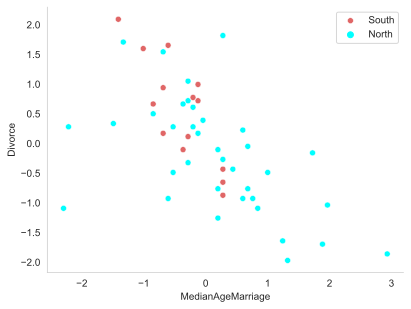

In [45]:
sns.scatterplot(x=standardize(df.MedianAgeMarriage), y=standardize(df.Divorce), hue=df.South, palette=palette)
plt.legend(loc='upper right', labels=['South', 'North'])
plt.grid(False)
sns.despine()

$D_i \sim Normal(\mu_i, \sigma)$,  
$\mu_i = \alpha + \beta_M M_i + \beta_A A_i$.  

$\alpha \sim Normal(0, 0.5)$,  
$\beta_M \sim Normal(0, 1)$,  
$\beta_A \sim Normal(0, 1)$,
$\sigma \sim Exponential(1)$.

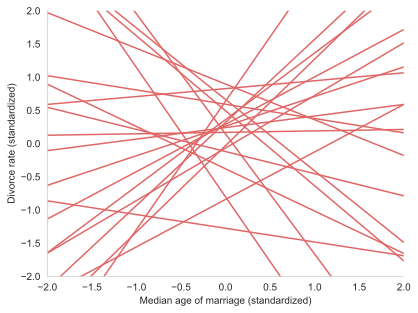

In [46]:
# prior predictive simulation
n = 20
a = stats.norm.rvs(0, 0.5, size=n)
# relationship is easier to visualize with just one independent variable
b_a = stats.norm.rvs(0, 1, size=n)
age_seq = np.linspace(-2, 2, 20)
for i in range(n):
    mu = a[i] + b_a[i] * age_seq
    plt.plot(age_seq, mu, color=palette[1])

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.xlabel("Median age of marriage (standardized)") 
plt.ylabel("Divorce rate (standardized)") 
plt.grid(False)
sns.despine()

In [47]:
# standardizing all data values
a_std = standardize(df.MedianAgeMarriage)
m_std = standardize(df.Marriage)
d_std = standardize(df.Divorce)

In [48]:
with pm.Model() as model:
    a = pm.Normal("a", 0, 0.5)
    b_a = pm.Normal("b_a", 0, 1)
    b_m = pm.Normal("b_m", 0, 1)
    mu = pm.Deterministic("mu", a + b_m * m_std + b_a * a_std)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu, sigma, observed=d_std)
    
    idata, _ = quap([a, b_a, b_m, sigma])

In [49]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,0.001,0.109,-0.200,0.209
b_a,-0.663,0.157,-0.960,-0.371
b_m,-0.102,0.158,-0.384,0.205
sigma,0.783,0.099,0.605,0.975


**Influence of median age at marriage appears stronger than marriage rate.**

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

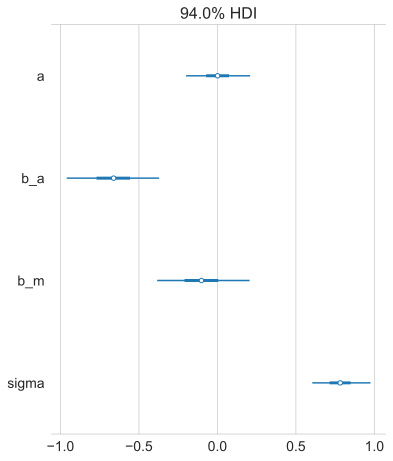

In [50]:
az.plot_forest(idata)

### The Pipe
#### $X \rightarrow Z \rightarrow Y$
$Z$&nbsp;is a "mediator", $X$ and $Y$ are associated. Influence of $X$ on $Y$ is transmitted through $Z$.  
Once stratified by $Z$, no association.

In [51]:
n = 1000
X = stats.bernoulli.rvs(0.5, size=n)
Z = stats.bernoulli.rvs((1 - X) * 0.1 + X * 0.9)
Y = stats.bernoulli.rvs((1 - Z) * 0.1 + Z * 0.9)

In [52]:
df = pd.DataFrame({"x": X, "y": Y, "z": Z})
df[['x', 'y']].value_counts()

x  y
0  0    407
1  1    402
0  1     97
1  0     94
Name: count, dtype: int64

In [53]:
df.x.corr(df.y)

0.6180050124485335

In [54]:
df[df.z == 0][['x', 'y']].value_counts()

x  y
0  0    402
   1     54
1  0     45
   1      4
Name: count, dtype: int64

In [55]:
df[df.z == 0].x.corr(df[df.z == 0].y)

-0.03415258633306327

In [56]:
# a continuous example
n = 500
X = stats.norm.rvs(size=n)
# logistic function
Z = stats.bernoulli.rvs(logistic(X))
Y = stats.norm.rvs(2 * Z - 1)

df = pd.DataFrame({"x": X, "y": Y, "z": Z})

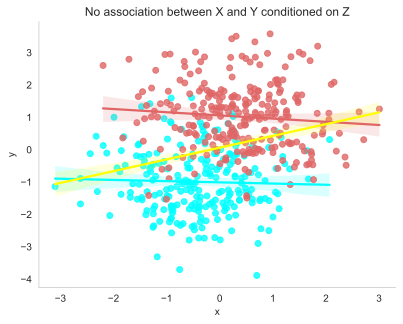

In [57]:
sns.regplot(x='x', y='y', data=df[df.z == 0], color=palette[0])
sns.regplot(x='x', y='y', data=df[df.z == 1], color=palette[1])
sns.regplot(x='x', y='y', data=df, color='yellow', scatter=False)
plt.title("No association between X and Y conditioned on Z")
plt.grid(False)
sns.despine()

### The Collider
#### $X \rightarrow Z \leftarrow Y$
$Z$&nbsp;is a "collider", $X$ and $Y$ are not associated. Once stratified by $Z$, the $X$ and $Y$ are associates.

In [58]:
n = 1000
X = stats.bernoulli.rvs(0.5, size=n)
Y = stats.bernoulli.rvs(0.5, size=n)
Z = stats.bernoulli.rvs(np.where(X + Y > 0, 0.9, 0.1))

df = pd.DataFrame({"x": X, "y": Y, "z": Z})
df[['x', 'y']].value_counts()

x  y
0  1    251
1  1    251
0  0    249
1  0    249
Name: count, dtype: int64

In [59]:
# X and Y are not associated
df.x.corr(df.y)

0.0

In [60]:
df[df.z == 0][['x', 'y']].value_counts()

x  y
0  0    225
1  1     27
0  1     26
1  0     23
Name: count, dtype: int64

In [61]:
df[df.z == 0].x.corr(df[df.z == 0].y)

0.4264391831741823

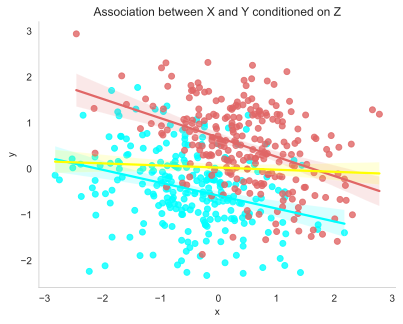

In [62]:
# a continuous example
n = 500
X = stats.norm.rvs(size=n)
Y = stats.norm.rvs(size=n)
Z = stats.bernoulli.rvs(logistic(2 * X + 2 * Y))

df = pd.DataFrame({"x": X, "y": Y, "z": Z})

sns.regplot(x='x', y='y', data=df[df.z == 0], color=palette[0])
sns.regplot(x='x', y='y', data=df[df.z == 1], color=palette[1])
sns.regplot(x='x', y='y', data=df, color='yellow', scatter=False)
plt.title("Association between X and Y conditioned on Z")
plt.grid(False)
sns.despine()

#### Collider Example
Some biases arise from conditioning on a collider (selection).

### The Descendant
#### $X \rightarrow Z \rightarrow Y$
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$↓$
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$A$
$A$&nbsp;is a "descendant". $X$ and $Y$ are associated through $Z$. Once stratified by $A$, $X$ and $Y$ are less associated.

In [63]:
n = 1000
X = stats.bernoulli.rvs(0.5, size=n)
Z = stats.bernoulli.rvs((1 - X) * 0.1 + X * 0.9)
Y = stats.bernoulli.rvs((1 - Z) * 0.1 + Z * 0.9)
A = stats.bernoulli.rvs((1 - Z) * 0.1 + Z * 0.9)

df = pd.DataFrame({"x": X, "y": Y, "z": Z, "a": A})
df[['x', 'y']].value_counts()

x  y
0  0    423
1  1    403
0  1     87
1  0     87
Name: count, dtype: int64

In [64]:
df.x.corr(df.y)

0.6518607442977206

In [65]:
df[df.a == 0][['x', 'y']].value_counts()

x  y
0  0    384
   1     47
1  1     45
   0     44
Name: count, dtype: int64

In [66]:
df[df.a == 0].x.corr(df[df.a == 0].y)

0.3914144730007803

Descendants are everywhere. Many measurements are proxies of what we want to measure.

### Unobserved Confounds

Unmeasured causes exist and can make inference difficult. For example, estimate the **direct** effect of grandparents' education $G$ on grandchildren's education $C$
<img src="img/fig4.1.png"/>

We need to block the pipe $G \rightarrow P \rightarrow C$. However, $P$ is both a mediator and a collider. Thus, we **cannot** estimate the **direct** effect of $G$ on $C$.

$C_i \sim Normal(\mu_i, \sigma)$,
$\mu_i = \alpha + \beta_G G_i + \beta_P P_i$. (condition on $P$)

In [67]:
n = 500
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

U = 2 * stats.bernoulli.rvs(0.5, size=n) - 1  # (-1, 1)
G = stats.norm.rvs(size=n)
P = stats.norm.rvs(b_GP * G + b_U * U)
C = stats.norm.rvs(b_PC * P + b_GC * G + b_U * U)
df = pd.DataFrame({"G": G, "P": P, "C": C, "U": U})

# Neighborhood (U) is unovserved and not part of the statistical model
with pm.Model() as model:
    a = pm.Normal("a", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    b_PC = pm.Normal("b_PC", 0, 1)
    b_GC = pm.Normal("b_GC", 0, 1)
    mu = pm.Deterministic("mu", a + b_GC * G + b_PC * P)
    c = pm.Normal("c", mu, sigma, observed=C)
    
    idata, _ = quap([a, b_GC, b_PC, sigma])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

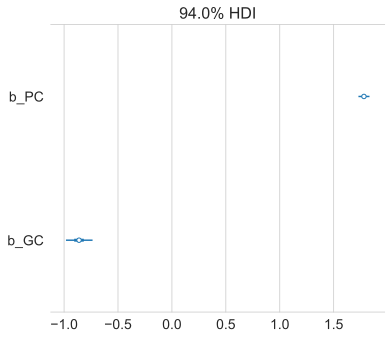

In [68]:
az.plot_forest(idata, var_names=["b_PC", "b_GC"])